In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
module = fc.FileCollection('/store/user/srosenzw/sixb/ntuples/Summer2018UL/maxbtag_4b/')

In [100]:
f_tree = "/store/user/srosenzw/sixb/ntuples/Summer2018UL/maxbtag_4b/Official_NMSSM/NMSSM_XToYHTo6B_MX-1200_MY-450_TuneCP5_13TeV-madgraph-pythia8/ntuple.root"
tree = Tree(f_tree)

100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


In [101]:
model = '/eos/uscms/store/user/ekoenig/weaver/models/exp_suzs/feynnet_6b/20230627_ranger_lr0.0047_batch1024_/'
ranker = eightb.load_weaver_output(
    tree, model, ['maxcomb','maxscore','minscore','feynnet_hx_m','feynnet_y_m', 'feynnet_hitk1'] 
)

In [102]:
fully_res = tree.nfound_select == 6
np.mean(fully_res)

0.34732187875732073

In [103]:
ak.mean(ranker['feynnet_hitk1']), ak.mean(ranker['feynnet_hitk1'][fully_res])

(0.035501428589897736, 0.01939326260934301)

In [104]:
jet_p4 = build_p4(tree, 'jet', use_regressed=False, extra=['signalId'])

def reconstruct(jet_p4, assignment, tag=''):
    if tag and not tag.endswith('_'): tag += '_'

    j_p4 = jet_p4[assignment]
    j1_p4, j2_p4 = j_p4[:,::2], j_p4[:,1::2]
    h_p4 = j1_p4 + j2_p4
    h_signalId = ak.where(j1_p4.signalId//2 == j2_p4.signalId//2, j1_p4.signalId//2, -1)
    y_p4 = h_p4[:,1] + h_p4[:,2]
    y_signalId = ak.where(h_signalId[:,1]//1 == h_signalId[:,2]//1, h_signalId[:,1]//1, -1)
    x_p4 = h_p4[:,0] + y_p4
    x_signalId = ak.where(h_signalId[:,0]//2 == y_signalId//2, h_signalId[:,0]//2, -1)
    h_pt_order = ak_rank(h_p4.pt, axis=1)
    j_pt_order = ak_rank(j_p4.pt, axis=1)
    hx_y_pt_order = h_pt_order * np.array([[10,1,1]])
    hx_y_j_pt_order = j_pt_order + hx_y_pt_order[:, [0,0,1,1,2,2]]
    j_order = ak.argsort(hx_y_j_pt_order, axis=1, ascending=False)
    h_order = ak.argsort(hx_y_pt_order, axis=1, ascending=False)

    j_p4 = j_p4[j_order]
    h_p4 = h_p4[h_order]
    h_signalId = h_signalId[h_order]
    p4vars = ['pt','eta','phi','m']
    return dict(
        **{f'{tag}x_{var}': getattr(x_p4, var) for var in p4vars},
        **{f'{tag}x_signalId': x_signalId},
        **{f'{tag}y_{var}': getattr(y_p4, var) for var in p4vars},
        **{f'{tag}y_signalId': y_signalId},
        **{f'{tag}h_{var}': getattr(h_p4, var) for var in p4vars},
        **{f'{tag}h_signalId': h_signalId},
        **{f'{tag}j_{var}': getattr(j_p4, var) for var in j_p4.fields},
    )

In [120]:
class f_load_feynnet_assignment(ParallelMethod):
    def __init__(self, model, extra=[], reco_event=True):
        super().__init__()
        self.model = model
        self.extra = extra
        self.reco_event = reco_event
    def start(self, tree):
        fields = ['maxcomb','maxscore','minscore'] + self.extra

        jet_p4 = build_p4(tree, prefix='jet', use_regressed=False, extra=['signalId', 'btag'])
        ranker = eightb.load_weaver_output(tree, self.model, fields=fields)

        assert len(ranker['maxcomb']) == len(jet_p4), f'Ranker output and jet collection have different lengths. Got {len(ranker["maxcomb"])} and {len(jet_p4)} respectively.'

        return dict(
            jet_p4=jet_p4,
            ranker=ranker,
            extra=self.extra,
        )
    def run(self, jet_p4, ranker, extra):
        score, assignment, minscore = ranker['maxscore'], ranker['maxcomb'], ranker['minscore']
        assignment = ak.values_astype(ak.from_regular(assignment), "int64")
        reconstruction = reconstruct(jet_p4, assignment)
        return dict(
            feynnet_maxscore=score,
            feynnet_minscore=minscore,
            **{f'feynnet_{field}':ak.from_regular(ranker[field]) for field in extra},
            **reconstruction,
        )
    def end(self, tree, **output):
        tree.extend(**output)


In [121]:
model = '/eos/uscms/store/user/ekoenig/weaver/models/exp_suzs/feynnet_6b/20230627_ranger_lr0.0047_batch1024_/'
load_feynnet = f_load_feynnet_assignment(model)

In [122]:
load_feynnet(tree)

In [123]:
tree.x_signalId[2], ranker['feynnet_hitk1'][2]

(-1, 1.0)

In [134]:
tree.j_signalId[2]

<Array [0, 1, 2, 3, -1, 4] type='6 * int32'>

In [131]:
ranker['feynnet_hx_m'][2], tree.h_m[2,0], ranker['feynnet_y_m'][2], tree.y_m[2]

(112.66973114013672, 112.67015075683594, 460.3088073730469, 460.30877685546875)

100%|██████████| 3/3 [00:00<00:00, 20.51it/s]


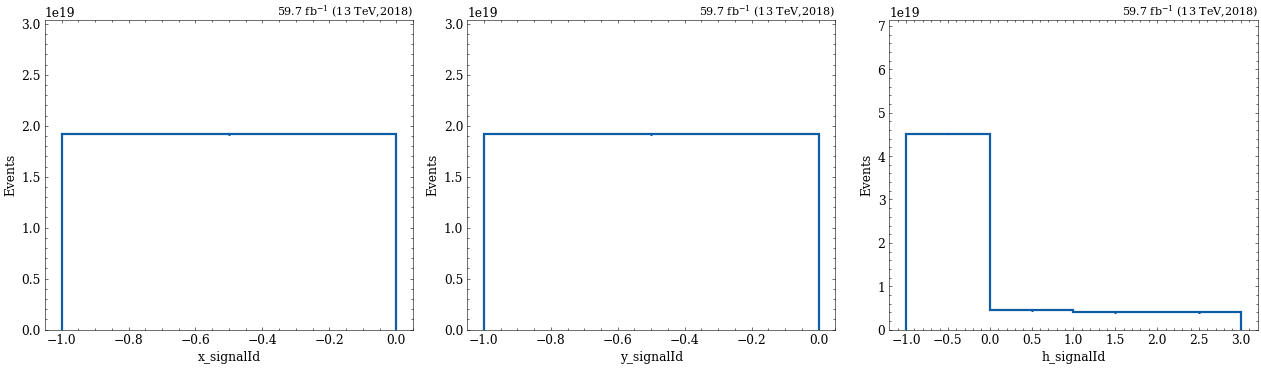

In [108]:
study.quick(
    [tree],
    masks=lambda t : t.nfound_select == 6,
    varlist=['x_signalId','y_signalId','h_signalId'],
)